In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# ================= Configuration Paths =================
BASE_DIR = "/content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2"
INFER_DIR = os.path.join(BASE_DIR, "infer_outputs")
CKPT_PATH = os.path.join(BASE_DIR, "best_mosei_fusion_decoder.pt")

EMOTIONS = ["Happy", "Sad", "Anger", "Fear", "Disgust", "Surprise"]
# Define a set of high-contrast colors suitable for publications
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# ================= Load Data =================
print(f"Loading data from: {INFER_DIR}")
probs = np.load(os.path.join(INFER_DIR, "test_y_prob.npy"))
y_true_cont = np.load(os.path.join(INFER_DIR, "test_y_true.npy"))
# Convert continuous labels (> 0) to binary ground truth
y_true = (y_true_cont > 0).astype(int)

# Load Beta (Mean) values, if available (Likely related to an uncertainty/beta decoder model)
beta_path = os.path.join(INFER_DIR, "test_beta_mean.npy")
betas = np.load(beta_path) if os.path.exists(beta_path) else None

# Load Thresholds
try:
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    # Retrieve the calibrated thresholds from the checkpoint
    thresholds = np.array(ckpt.get("val_calibrated_thresholds"))
    print(f"✅ Loaded Thresholds: {np.round(thresholds, 3)}")
except Exception:
    # Fallback if checkpoint loading fails
    thresholds = np.full(6, 0.5)
    print("⚠️ Checkpoint load failed, using default 0.5")

# Apply the loaded/default thresholds to the probabilities to get binary predictions
y_pred = (probs >= thresholds[None, :]).astype(int)
print("Ready.")

Loading data from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs
✅ Loaded Thresholds: [0.05 0.05 0.15 0.2  0.25 0.35]
Ready.


# 6-in-1 Precision-Recall (P-R) Curve

This is the most important figure for demonstrating the model's overall performance. It is more suitable for imbalanced datasets than the ROC curve. Reviewers will look at this first.

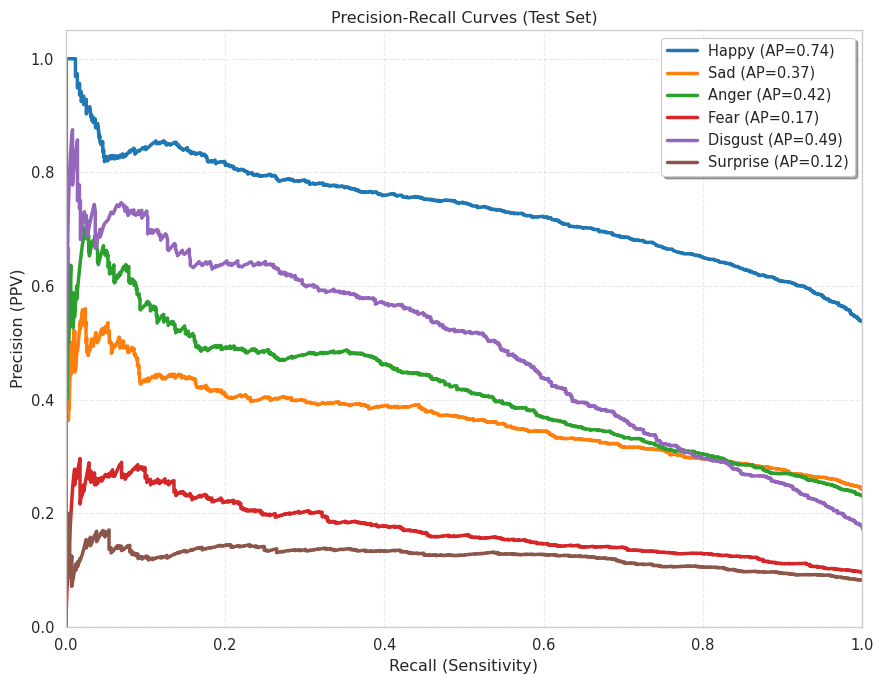

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# (Assuming EMOTIONS, y_true, probs, and COLORS are already defined)

plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 12}) # Adjust font size, suitable for publications/papers

for i, name in enumerate(EMOTIONS):
    # Only plot if the class has positive samples
    if y_true[:, i].sum() > 0:
        prec, rec, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        ap = average_precision_score(y_true[:, i], probs[:, i])
        # Plot the curve, making it bold (lw=2.5)
        plt.plot(rec, prec, lw=2.5, color=COLORS[i], label=f'{name} (AP={ap:.2f})')

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend(loc="upper right", frameon=True, shadow=True)
plt.grid(alpha=0.4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# Positive vs. Negative Sample Score Distribution

This plot is highly persuasive. It explains **"Why is your threshold chosen so low (e.g., 0.05)?"** — because the confidence scores of the positive samples are not high themselves, but they are clearly distinguishable from the negative samples. This demonstrates that your calibration strategy is scientific, not arbitrary.

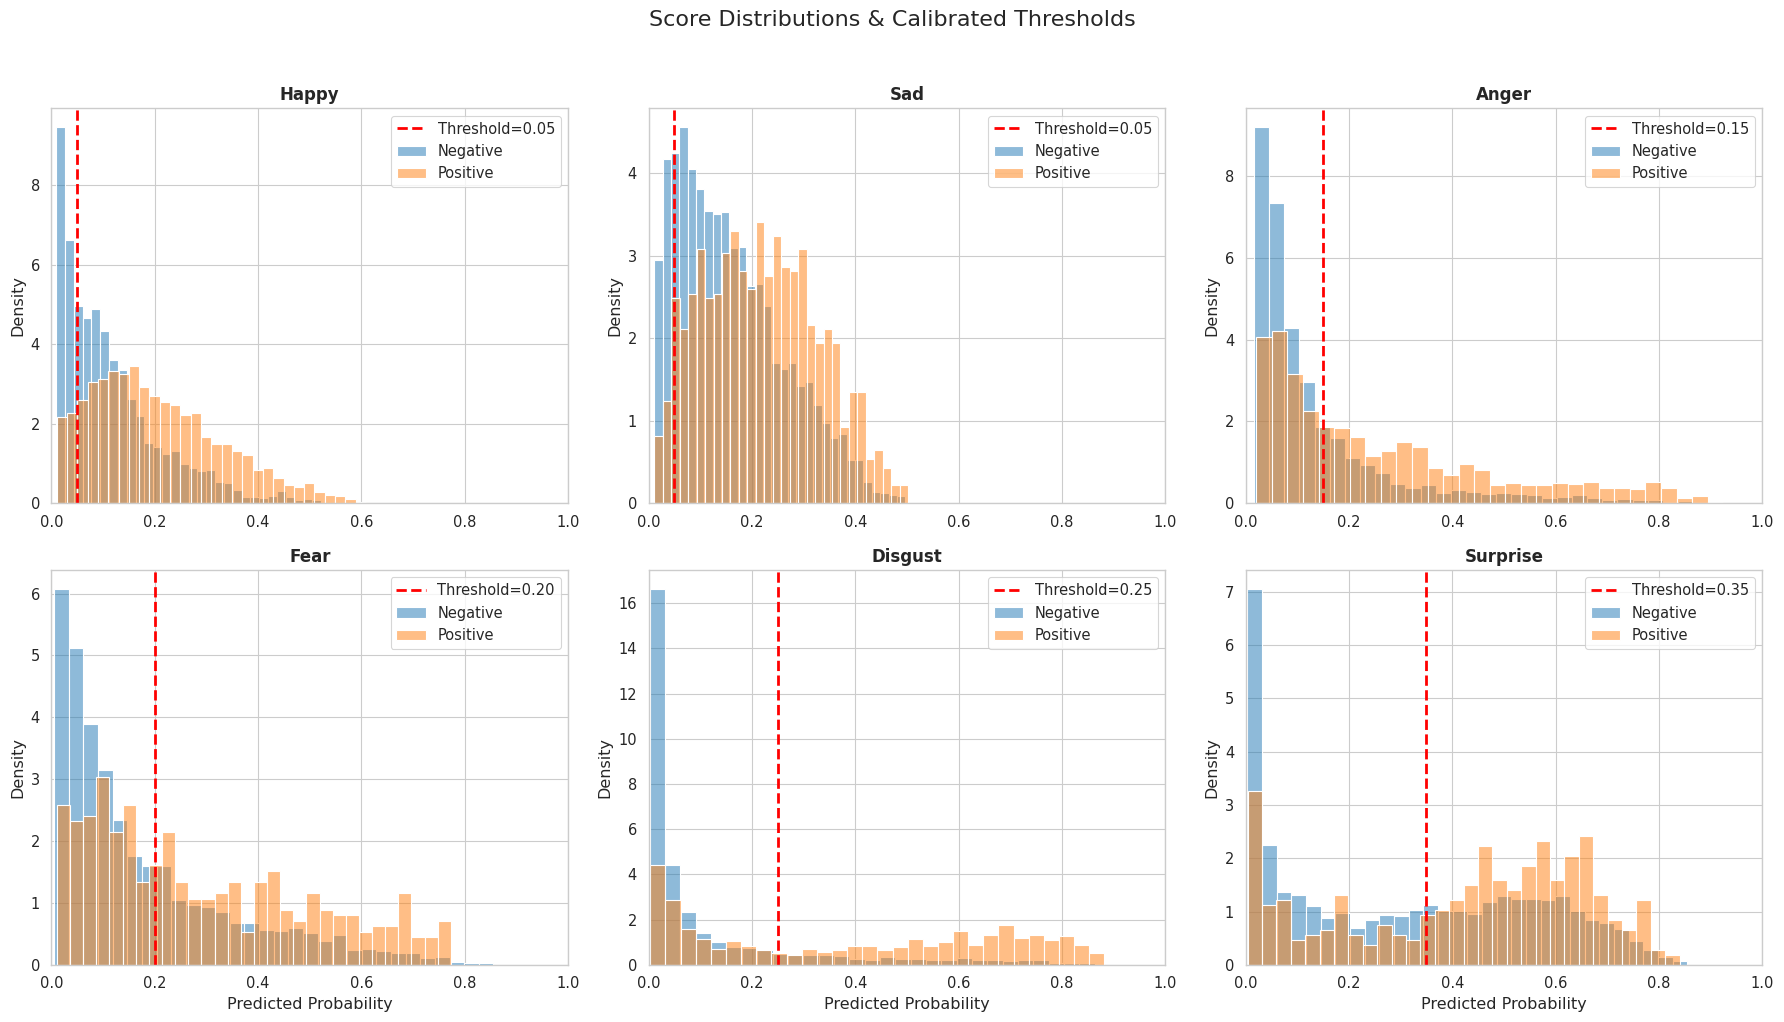

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
# (Assuming EMOTIONS, y_true, probs, and thresholds are already defined and loaded)

# Create a 2x3 grid of subplots for the 6 emotions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, name in enumerate(EMOTIONS):
    ax = axes[i]

    # Separate the predicted scores for positive (y=1) and negative (y=0) samples
    pos_scores = probs[y_true[:, i] == 1, i]
    neg_scores = probs[y_true[:, i] == 0, i]

    # Plot histograms (density normalized)
    sns.histplot(neg_scores, bins=30, color='tab:blue', alpha=0.5, label='Negative', ax=ax, stat='density')
    sns.histplot(pos_scores, bins=30, color='tab:orange', alpha=0.5, label='Positive', ax=ax, stat='density')

    # Plot the learned threshold line
    th = thresholds[i]
    ax.axvline(th, color='red', linestyle='--', linewidth=2, label=f"Threshold={th:.2f}")

    ax.set_title(f"{name}", fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlim(0, 1.0)
    # Only show the x-label on the bottom row plots for better visualization
    if i >= 3: ax.set_xlabel("Predicted Probability")

plt.suptitle("Score Distributions & Calibrated Thresholds", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Confusion Matrix & Label Correlation

Left Plot (Correlation): Demonstrates that the model has learned the logical relationships between emotions (e.g., Happy and Sad are mutually exclusive).

Right Plot (Confusion Matrix): Shows specific misclassification scenarios (e.g., Happy has high recall but also many misclassifications).

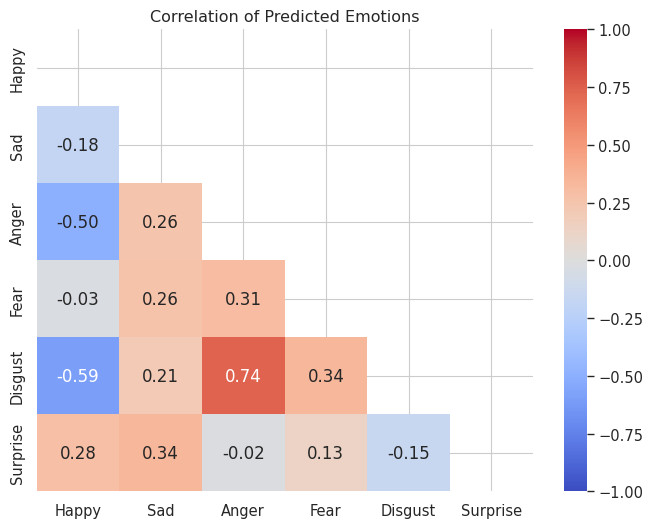

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# (Assuming EMOTIONS and y_pred are already defined)

# --- 1. Label Correlation (Correlation of Predicted Values) ---
plt.figure(figsize=(8, 6))
# Calculate the correlation matrix of the predicted binary labels
corr = np.corrcoef(y_pred.T)
# Create a mask to show only the lower triangle (to avoid redundancy)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=EMOTIONS, yticklabels=EMOTIONS,
            mask=mask, vmin=-1, vmax=1)
plt.title("Correlation of Predicted Emotions")
plt.show()

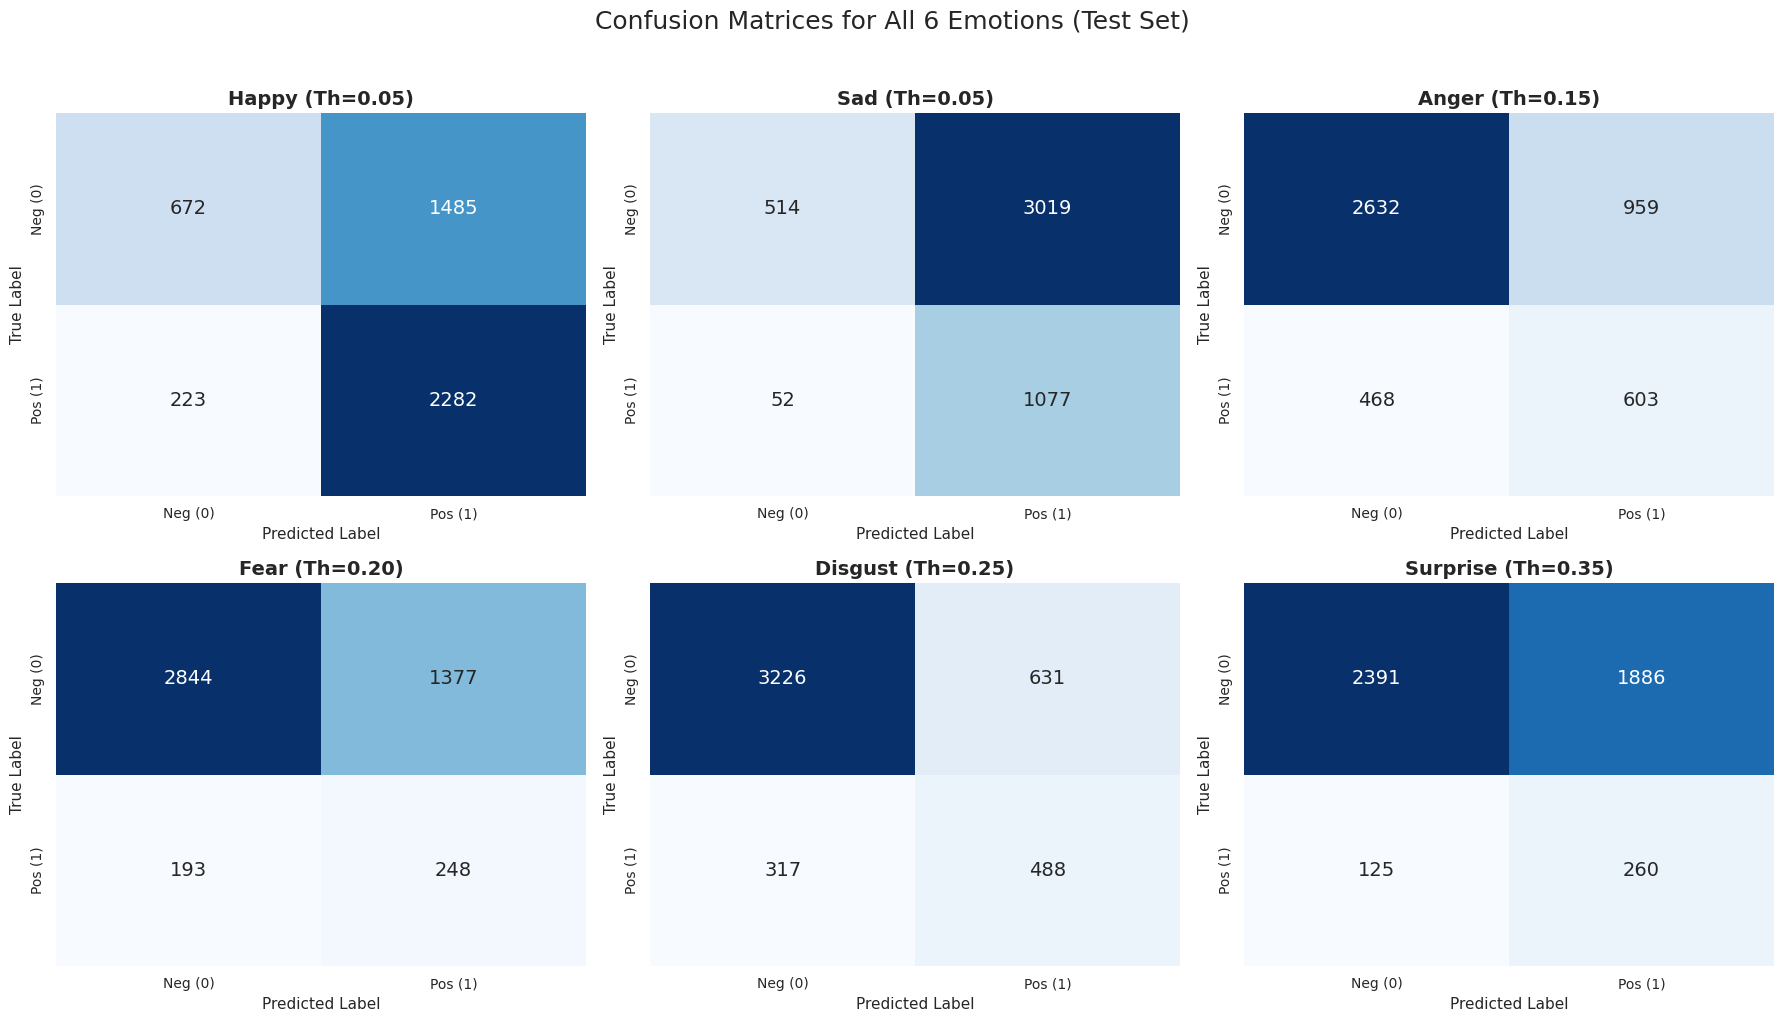

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# (Assuming EMOTIONS, y_true, y_pred, and thresholds are already defined)

# ================= [Complete Set] Confusion Matrices for All 6 Emotions =================
# Set up the canvas size (width, height)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Flatten the 2x3 grid into a 1D array for easier looping

for i, name in enumerate(EMOTIONS):
    ax = axes[i]

    # Calculate the confusion matrix for the current emotion
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])

    # Plot the heatmap (using the blue colormap 'Blues', number format is integer 'd')
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax, annot_kws={"size": 14})

    # Set the title (displaying the current threshold used)
    curr_th = thresholds[i]
    ax.set_title(f"{name} (Th={curr_th:.2f})", fontsize=14, fontweight='bold')

    # Label settings
    ax.set_xlabel("Predicted Label", fontsize=11)
    ax.set_ylabel("True Label", fontsize=11)
    ax.set_xticklabels(["Neg (0)", "Pos (1)"], fontsize=10)
    ax.set_yticklabels(["Neg (0)", "Pos (1)"], fontsize=10)

# Adjust layout to prevent overlap
plt.suptitle("Confusion Matrices for All 6 Emotions (Test Set)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Beta Gating Distribution

Direct evidence of the model's **"Adaptive Fusion"** capability. It demonstrates that the model dynamically weighs audio and text.

The $\beta$ value represents the weights of Audio and Text.

$\beta > 0.5$: Favors Audio

$\beta < 0.5$: Favors Text

$\beta \approx 0.5$: Balanced Fusion

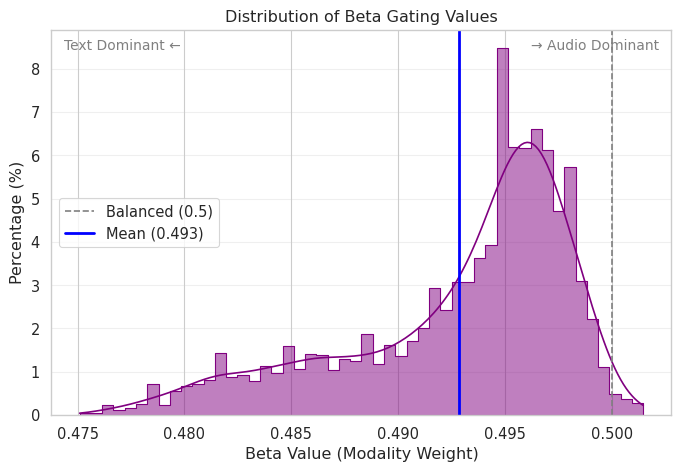

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (Assuming 'betas' is defined and loaded from 'test_beta_mean.npy')

if betas is not None:
    plt.figure(figsize=(8, 5))

    # Flatten the data (from all time steps/samples into a single array)
    beta_flat = betas.flatten()
    mean_val = np.mean(beta_flat)

    # Plot histogram with Kernel Density Estimate (KDE)
    sns.histplot(beta_flat, bins=50, kde=True, color="purple", element="step", stat='percent')

    # Add reference lines
    plt.axvline(0.5, color='gray', linestyle='--', label="Balanced (0.5)")
    plt.axvline(mean_val, color='blue', linestyle='-', linewidth=2, label=f"Mean ({mean_val:.3f})")

    # Add text annotations (using relative coordinates to stay anchored to the plot corners)
    plt.text(0.02, 0.95, "Text Dominant ←", transform=plt.gca().transAxes, fontsize=10, color='gray', ha='left')
    plt.text(0.98, 0.95, "→ Audio Dominant", transform=plt.gca().transAxes, fontsize=10, color='gray', ha='right')

    # plt.xlim(0, 1)
    plt.xlabel("Beta Value (Modality Weight)")
    plt.ylabel("Percentage (%)")
    plt.title("Distribution of Beta Gating Values")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [40]:
# ================= 6. [微观分析] 可解释性热力图 (Attention Heatmaps) =================
# 这一步负责画出论文 Case Study 部分的图：展示模型关注了哪里。

# 1. 加载 Attention 数据
attn_path = os.path.join(INFER_DIR, "test_attentions.pt")
print(f"Loading Attention Maps from: {attn_path}")

if os.path.exists(attn_path):
    # [关键修复] 加上 weights_only=False 以允许加载我们存进去的 Numpy 数组
    attn_data = torch.load(attn_path, map_location="cpu", weights_only=False)
    print(f"✅ Loaded! Captured batches: {len(attn_data['encoder'])}")
else:
    print("❌ 错误: 找不到 attention 文件。请检查 infer 是否开启了 --dump_attn")

# 2. 定义绘图函数
def plot_case_study(batch_idx, sample_in_batch):
    # ... (前部分逻辑不变) ...
    # 计算全局索引
    BATCH_SIZE = 8
    global_idx = batch_idx * BATCH_SIZE + sample_in_batch

    if global_idx >= len(probs):
        print("索引越界")
        return

    # 获取标签
    curr_prob = probs[global_idx]
    curr_true = y_true[global_idx]
    true_str = [EMOTIONS[i] for i, v in enumerate(curr_true) if v > 0]
    pred_str = [f"{EMOTIONS[i]}({p:.2f})" for i, p in enumerate(curr_prob) if p > 0.15]

    # 提取数据
    try:
        enc_map = attn_data['encoder'][batch_idx][-1]['audio_queries_text'][sample_in_batch]
        dec_map = attn_data['decoder'][batch_idx][-1][sample_in_batch]
    except:
        return

    # ================= [优化] 自动裁剪 Padding =================
    # 原理：找到最后一个有注意力的位置，切掉后面的 0

    # 1. 裁剪 Encoder (X轴是文本长度)
    # 计算每一列(Text Token)的总热度
    text_activity = enc_map.sum(axis=0)
    # 找到最后一个非零(或大于极小值)的索引
    valid_text_len = np.max(np.where(text_activity > 0.001)[0]) + 1
    # 裁剪
    enc_map_cropped = enc_map[:, :valid_text_len]

    # 2. 裁剪 Decoder (X轴是融合序列长度，通常等于文本长度)
    # 同样逻辑，裁剪 X 轴
    seq_activity = dec_map.sum(axis=0)
    valid_seq_len = np.max(np.where(seq_activity > 0.001)[0]) + 1
    dec_map_cropped = dec_map[:, :valid_seq_len]
    # ========================================================

    # --- 绘图 ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 8)) # 高度改小一点，更紧凑
    fig.suptitle(f"Sample #{global_idx}\nTrue: {true_str} | Pred: {pred_str}",
                 fontsize=14, fontweight='bold', y=0.98)

    # 图 1: Cross-Modal
    sns.heatmap(enc_map_cropped, ax=axes[0], cmap="viridis", cbar=True)
    axes[0].set_title("a) Cross-Modal Alignment (Audio frames → Text tokens)")
    axes[0].set_ylabel("Audio Frames")
    axes[0].set_xlabel(f"Text Tokens (Valid Len: {valid_text_len})")

    # 图 2: Emotion Decoder
    sns.heatmap(dec_map_cropped, ax=axes[1], cmap="magma", cbar=True)
    axes[1].set_title("b) Emotion Attribution (Emotion Query → Fused Sequence)")
    axes[1].set_yticks(np.arange(len(EMOTIONS)) + 0.5)
    axes[1].set_yticklabels(EMOTIONS, rotation=0)
    axes[1].set_xlabel("Fused Time Steps")

    plt.tight_layout()
    plt.show()

Loading Attention Maps from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/test_attentions.pt
✅ Loaded! Captured batches: 125


Searching for samples with [Exact Match] predictions...
Using thresholds for determination: [0.05       0.05       0.15000001 0.2        0.25       0.34999999]

🎉 Found perfect sample #1! Global Index: 17
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.34 0.05 0.03 0.04 0.   0.29])


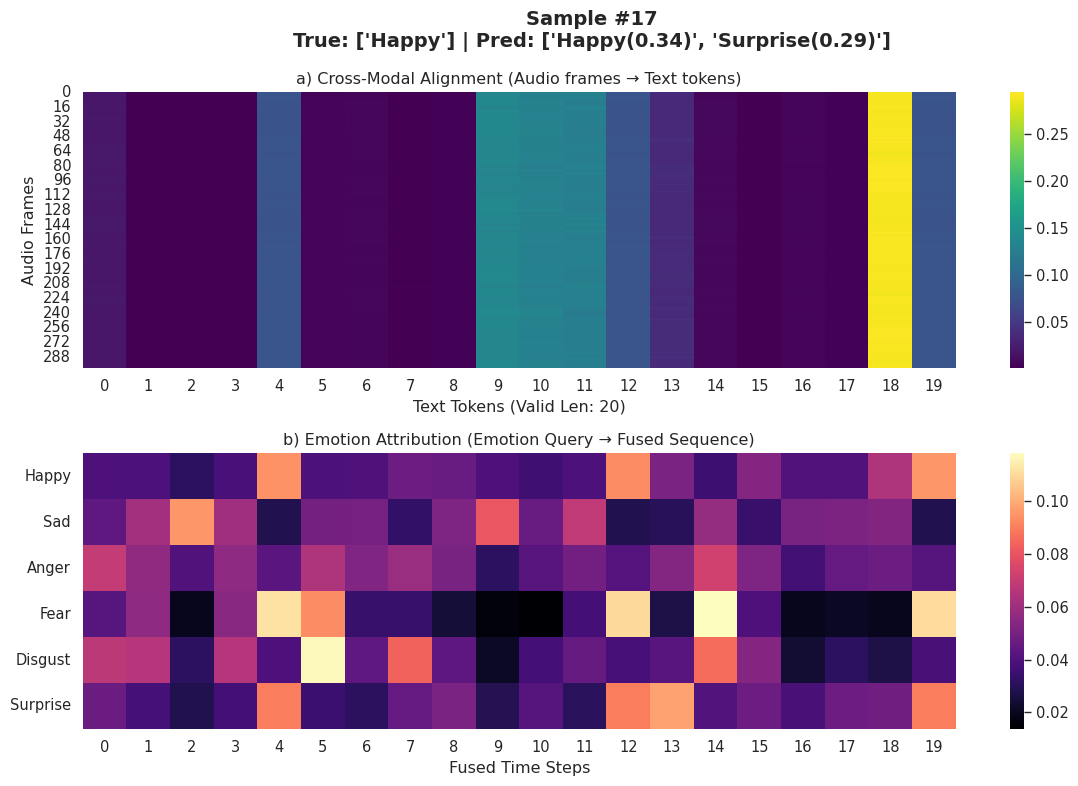


🎉 Found perfect sample #2! Global Index: 40
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.43 0.02 0.02 0.01 0.   0.03])


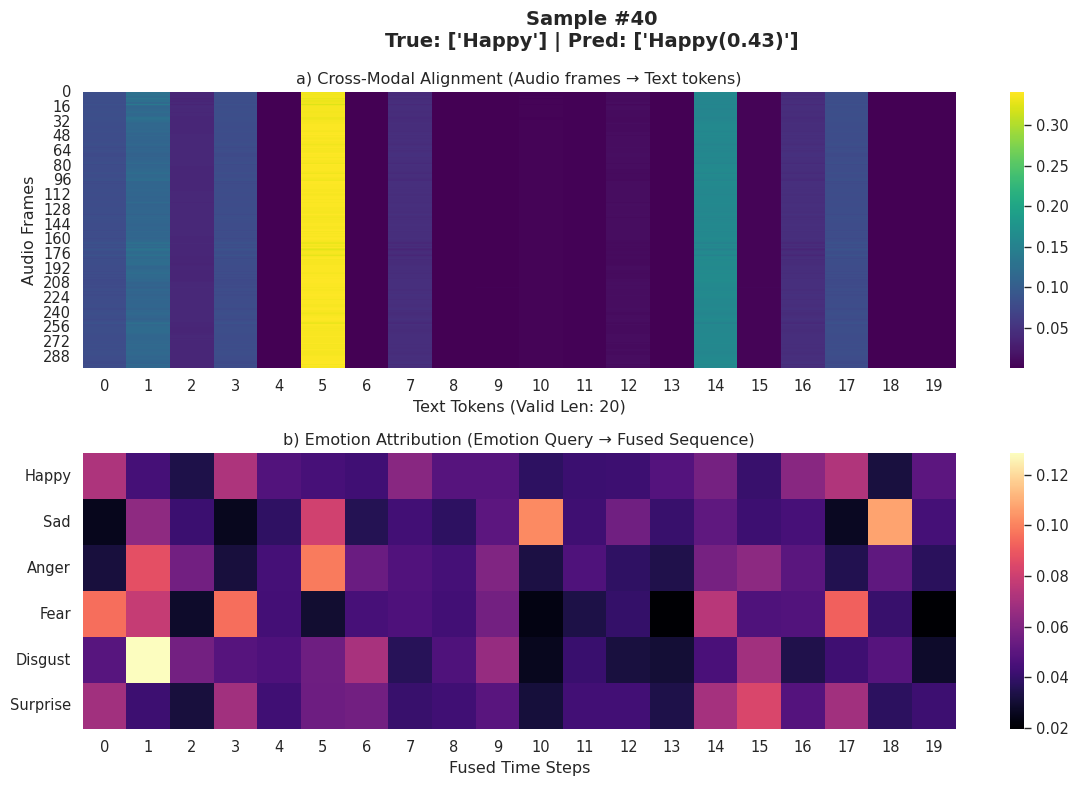


🎉 Found perfect sample #3! Global Index: 49
Emotion Categories: ['Sad', 'Anger']
True Labels: [0 1 1 0 0 0]
Predicted Result: [0 1 1 0 0 0] (Prob: [0.02 0.17 0.19 0.03 0.14 0.2 ])


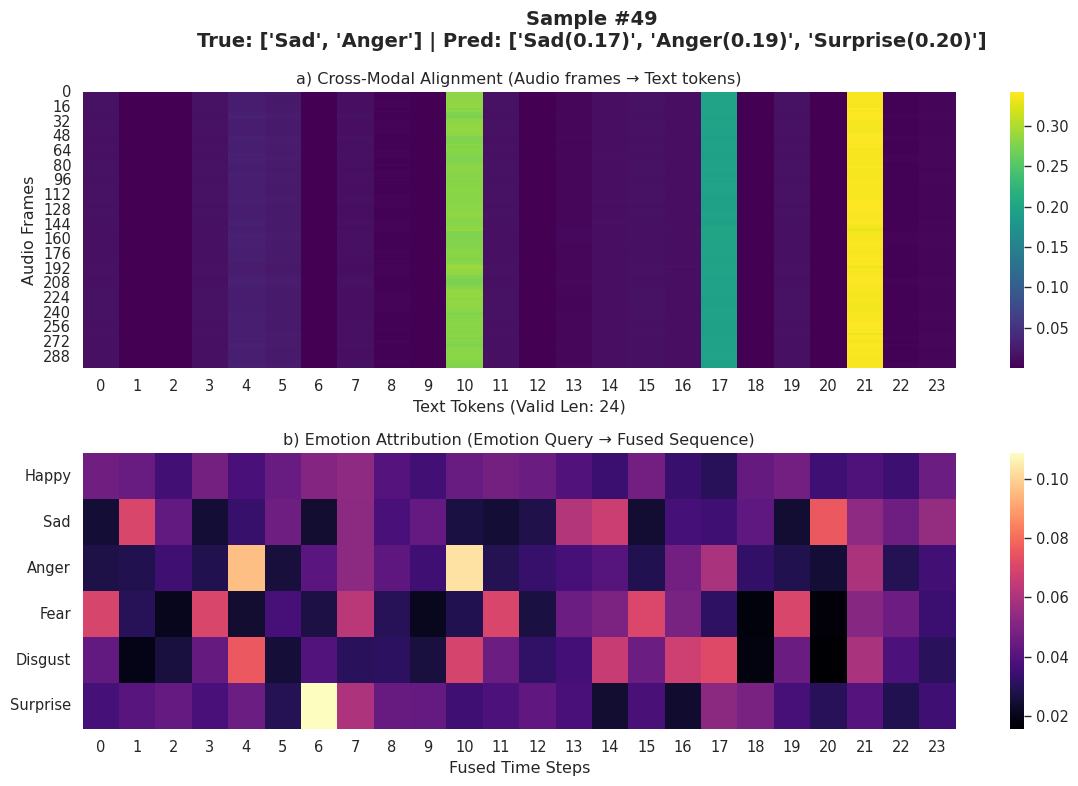


🎉 Found perfect sample #4! Global Index: 80
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.22 0.03 0.03 0.01 0.   0.06])


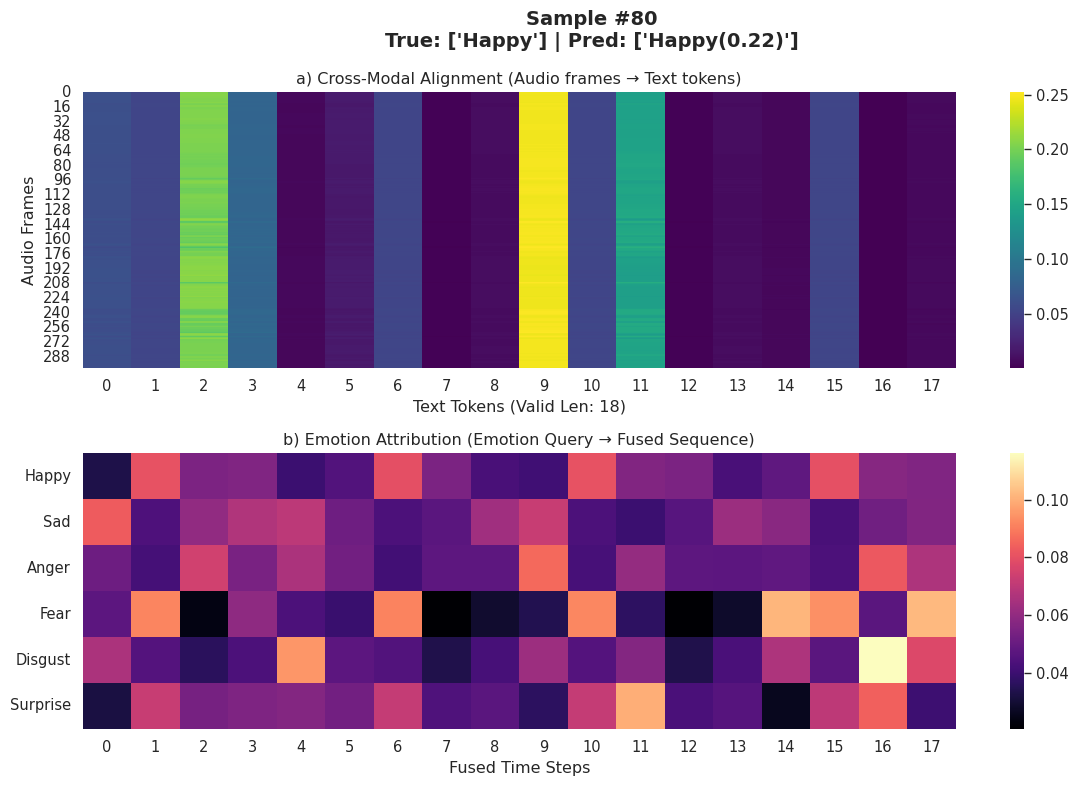


🎉 Found perfect sample #5! Global Index: 83
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.27 0.02 0.02 0.01 0.   0.03])


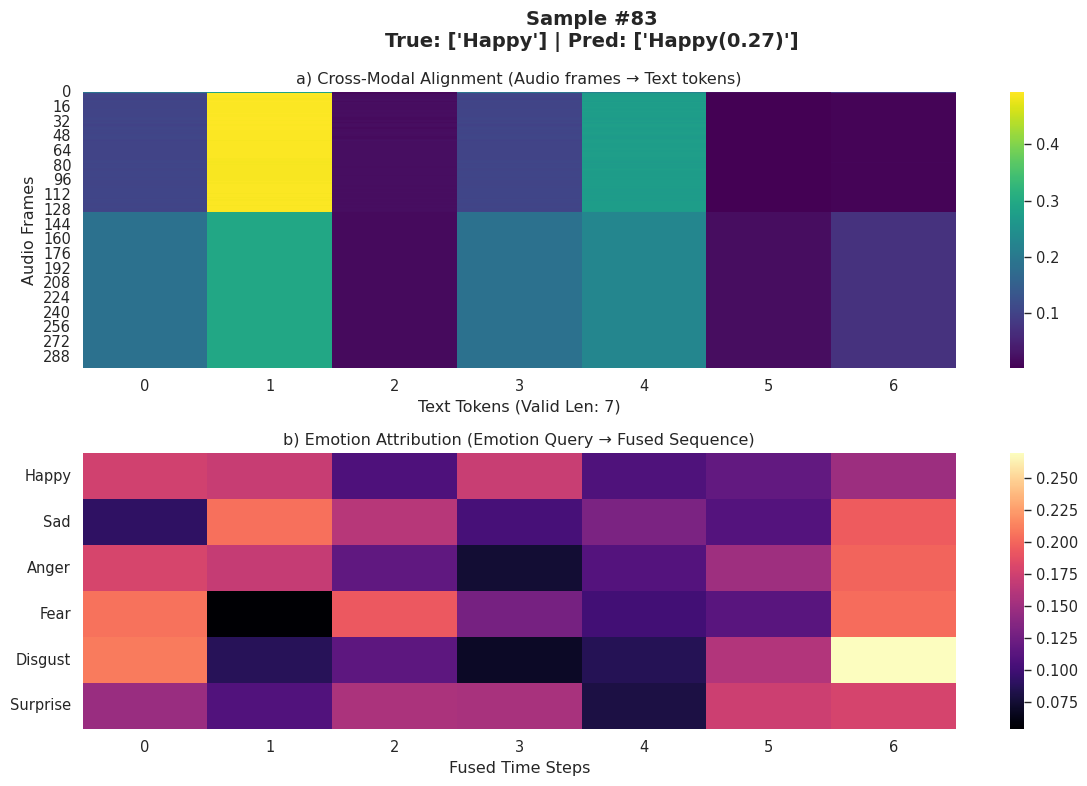


🎉 Found perfect sample #6! Global Index: 107
Emotion Categories: ['Happy', 'Sad']
True Labels: [1 1 0 0 0 0]
Predicted Result: [1 1 0 0 0 0] (Prob: [0.08 0.09 0.07 0.05 0.07 0.01])


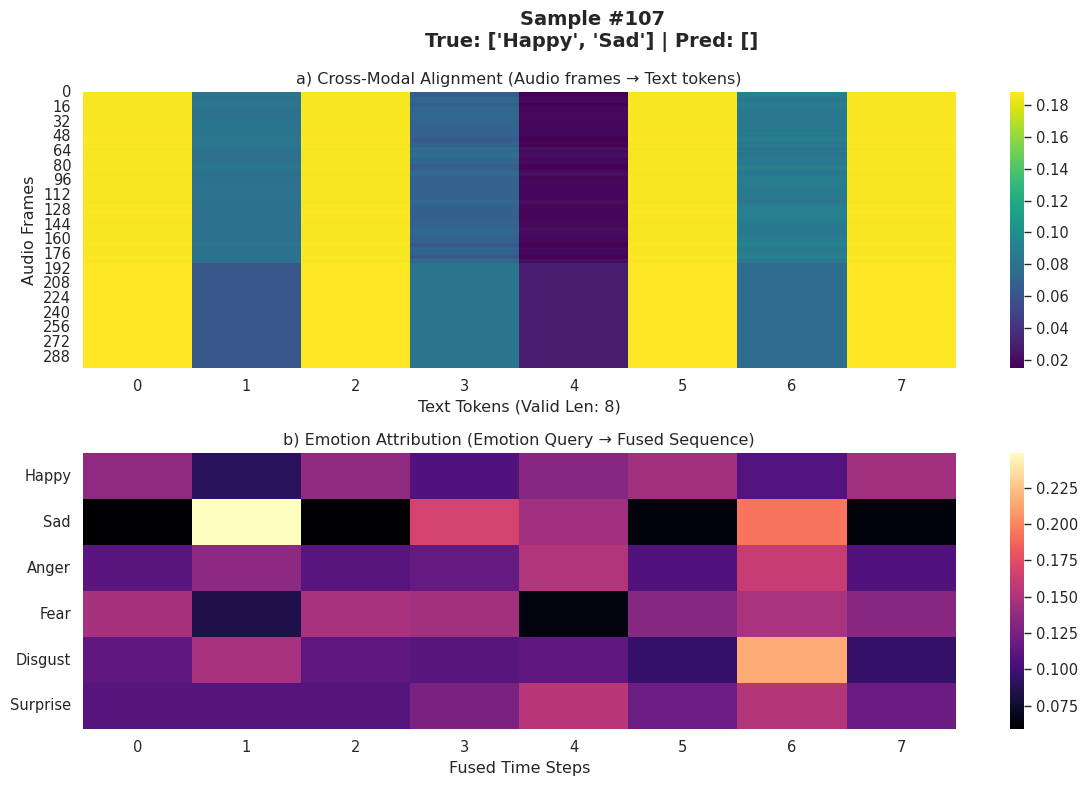


🎉 Found perfect sample #7! Global Index: 176
Emotion Categories: ['Sad', 'Anger', 'Disgust']
True Labels: [0 1 1 0 1 0]
Predicted Result: [0 1 1 0 1 0] (Prob: [0.02 0.3  0.8  0.13 0.8  0.09])


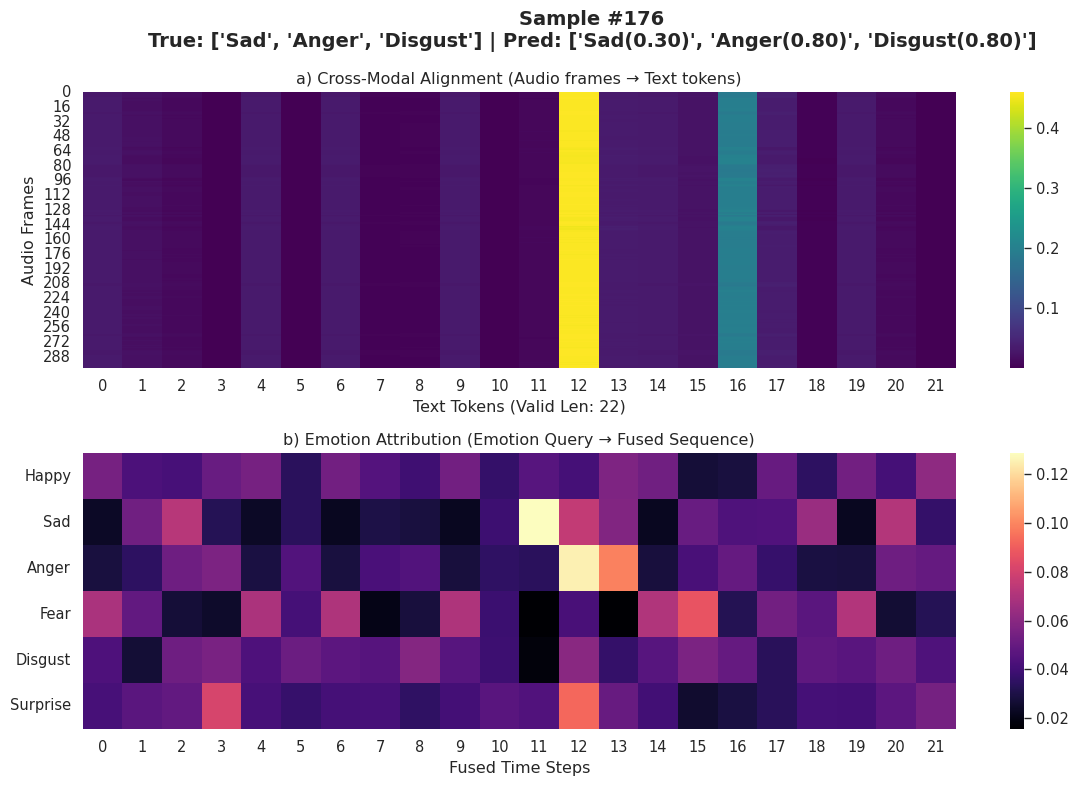


🎉 Found perfect sample #8! Global Index: 202
Emotion Categories: ['Sad', 'Anger', 'Disgust']
True Labels: [0 1 1 0 1 0]
Predicted Result: [0 1 1 0 1 0] (Prob: [0.02 0.33 0.62 0.11 0.76 0.01])


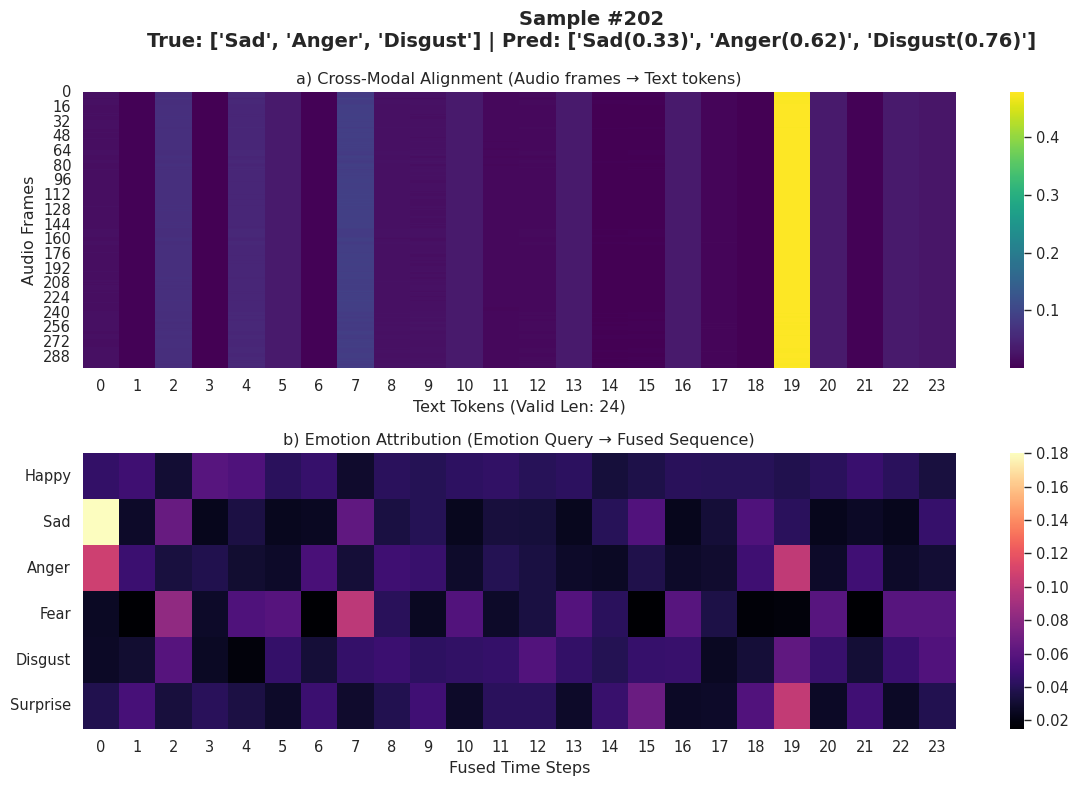


🎉 Found perfect sample #9! Global Index: 204
Emotion Categories: ['Sad', 'Anger', 'Disgust']
True Labels: [0 1 1 0 1 0]
Predicted Result: [0 1 1 0 1 0] (Prob: [0.03 0.24 0.74 0.14 0.72 0.05])


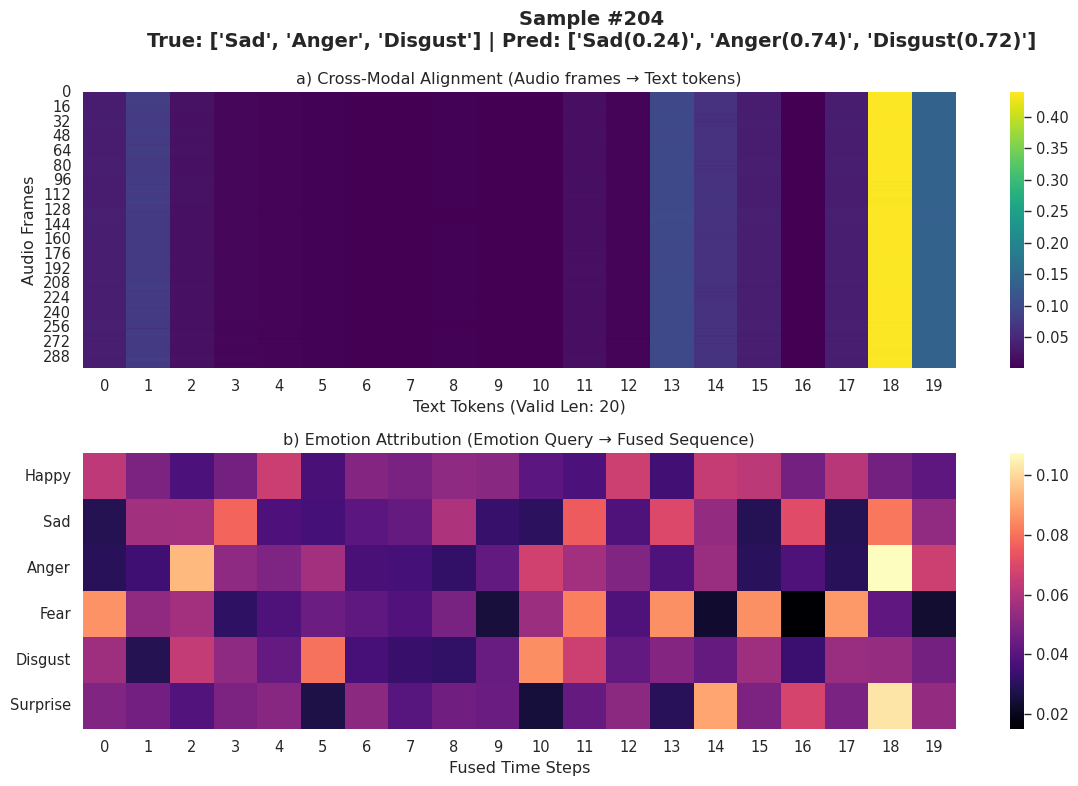


🎉 Found perfect sample #10! Global Index: 210
Emotion Categories: ['Sad', 'Anger', 'Fear', 'Disgust']
True Labels: [0 1 1 1 1 0]
Predicted Result: [0 1 1 1 1 0] (Prob: [0.04 0.41 0.38 0.61 0.75 0.34])


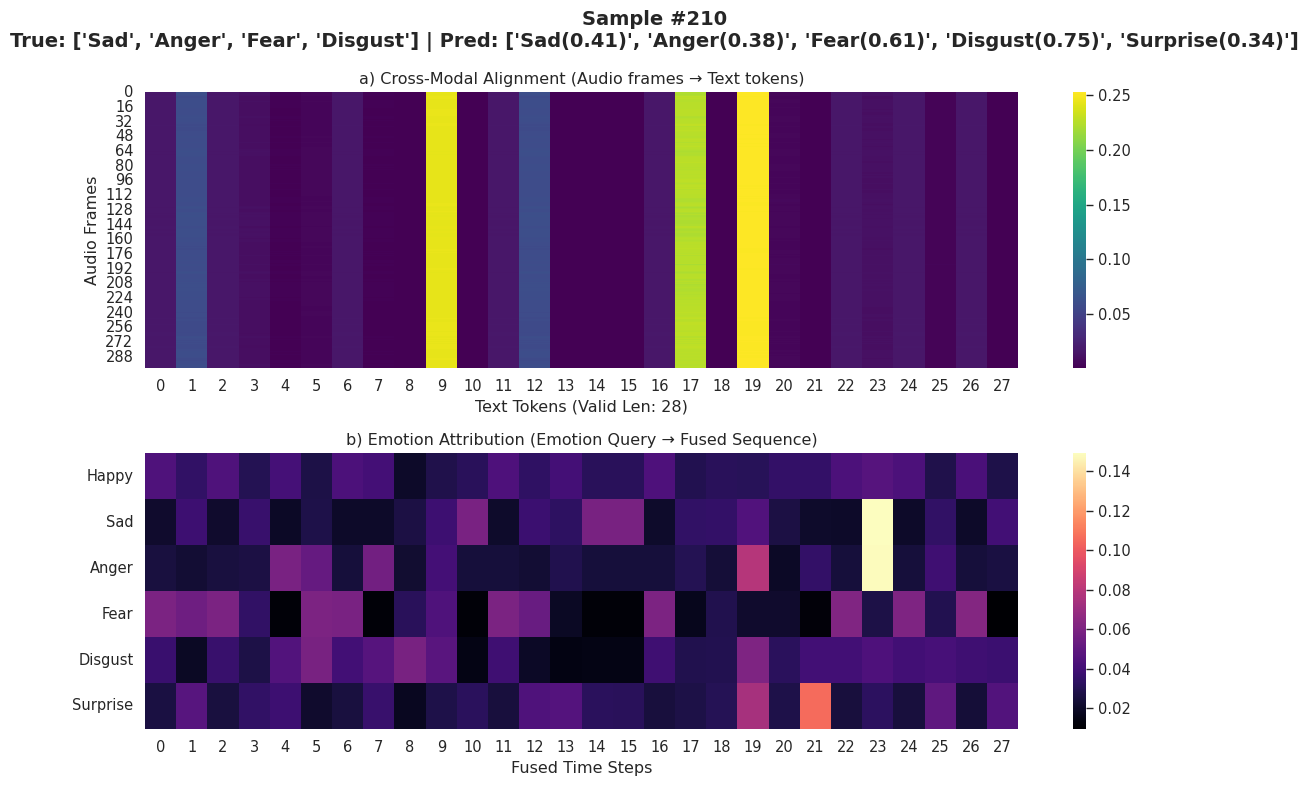


🎉 Found perfect sample #11! Global Index: 232
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.43 0.02 0.02 0.02 0.   0.02])


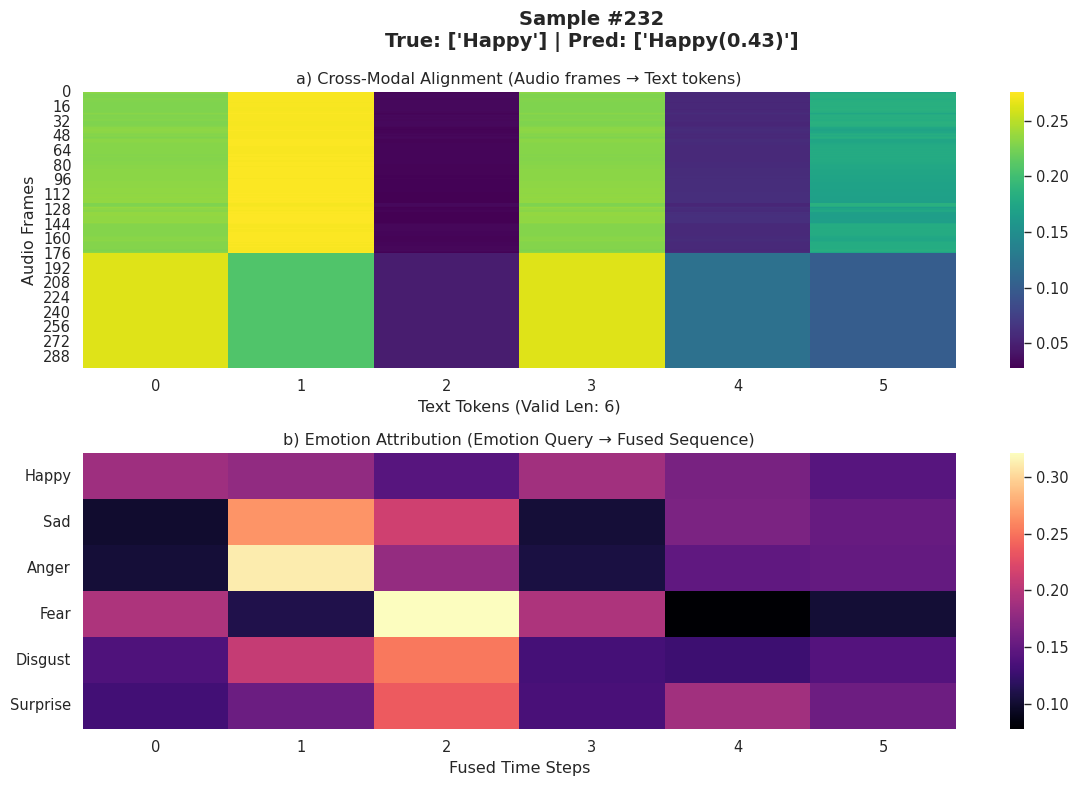


🎉 Found perfect sample #12! Global Index: 249
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.19 0.03 0.02 0.01 0.   0.04])


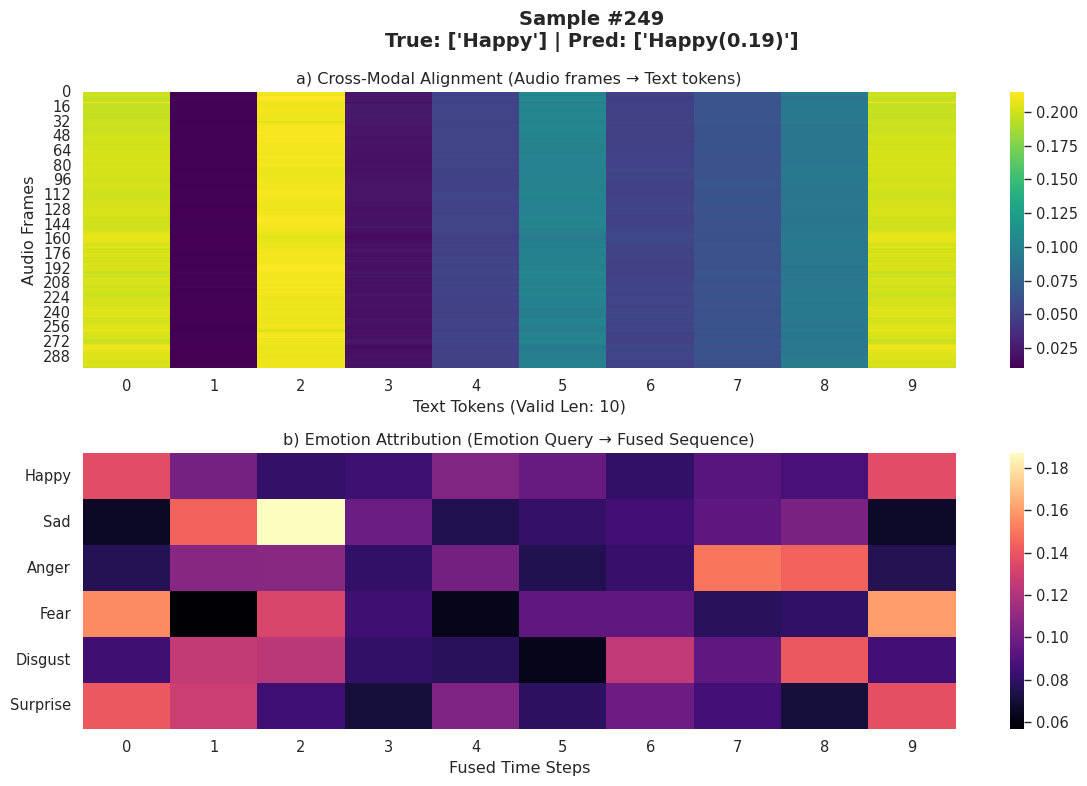


🎉 Found perfect sample #13! Global Index: 288
Emotion Categories: ['Sad', 'Anger', 'Fear', 'Disgust']
True Labels: [0 1 1 1 1 0]
Predicted Result: [0 1 1 1 1 0] (Prob: [0.02 0.4  0.25 0.21 0.6  0.01])


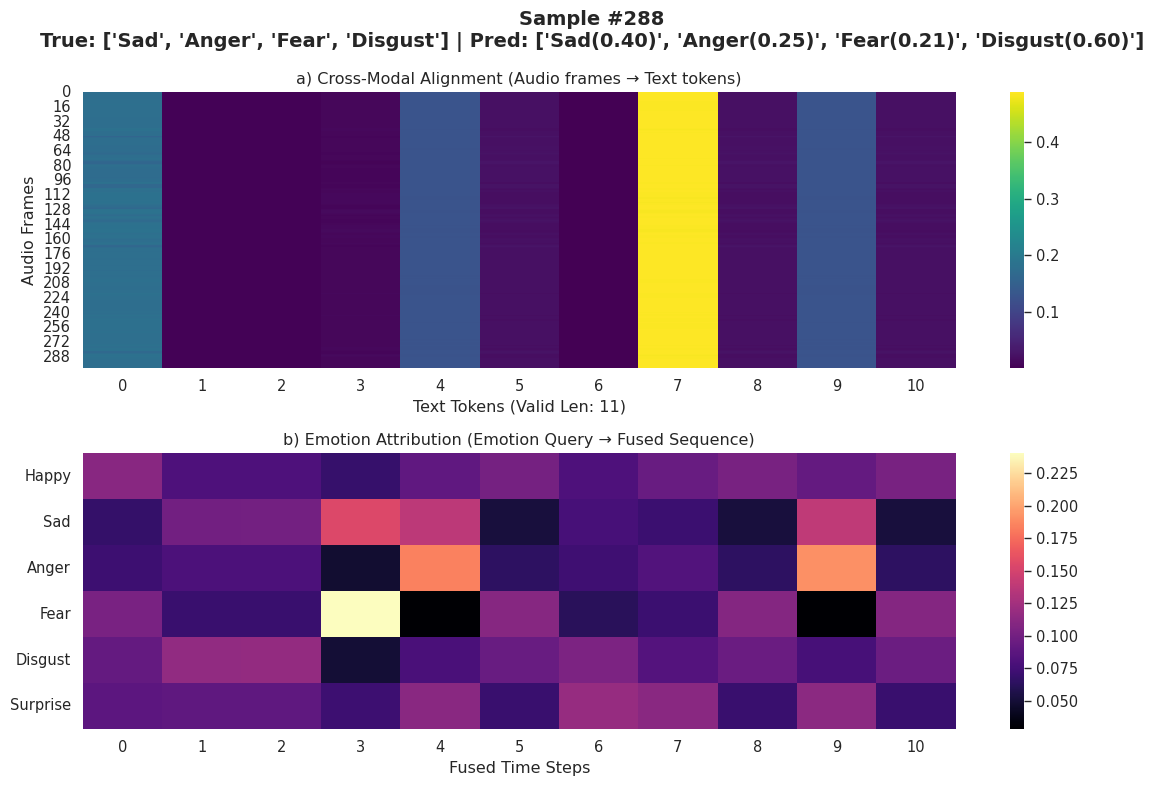


🎉 Found perfect sample #14! Global Index: 343
Emotion Categories: ['Happy', 'Sad', 'Surprise']
True Labels: [1 1 0 0 0 1]
Predicted Result: [1 1 0 0 0 1] (Prob: [0.13 0.24 0.13 0.1  0.05 0.64])


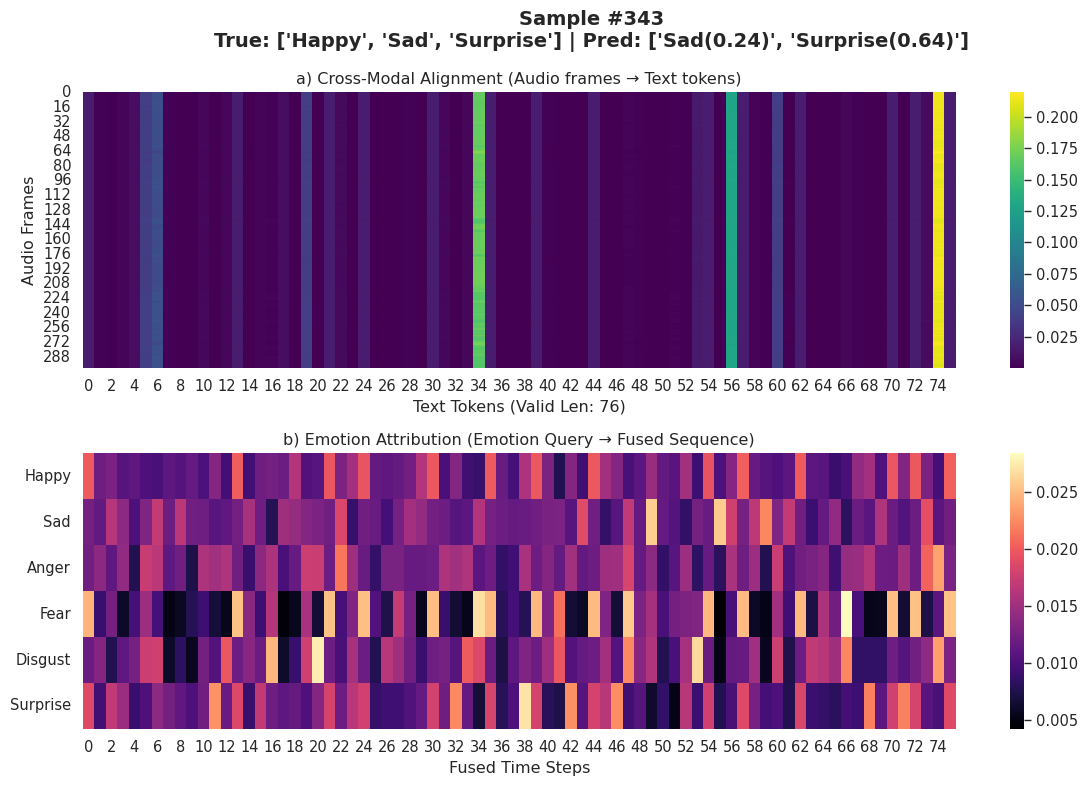


🎉 Found perfect sample #15! Global Index: 346
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.29 0.02 0.03 0.01 0.   0.02])


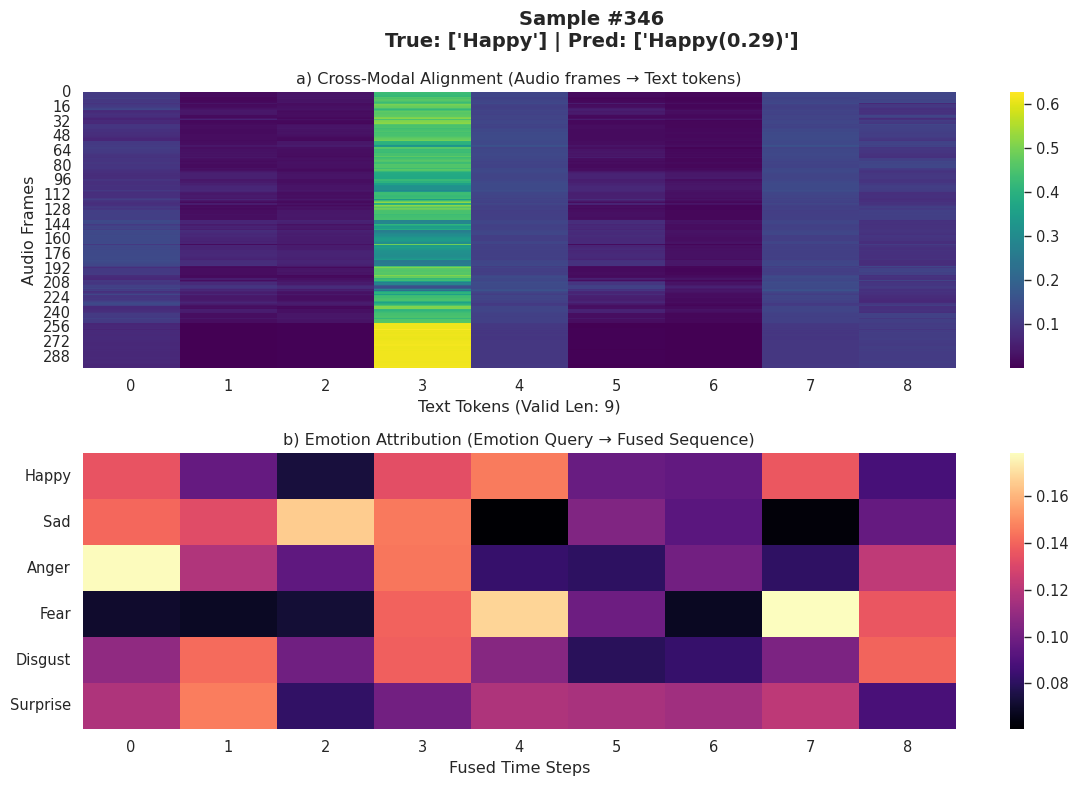


🎉 Found perfect sample #16! Global Index: 350
Emotion Categories: ['Sad', 'Anger', 'Disgust']
True Labels: [0 1 1 0 1 0]
Predicted Result: [0 1 1 0 1 0] (Prob: [0.02 0.31 0.71 0.15 0.78 0.01])


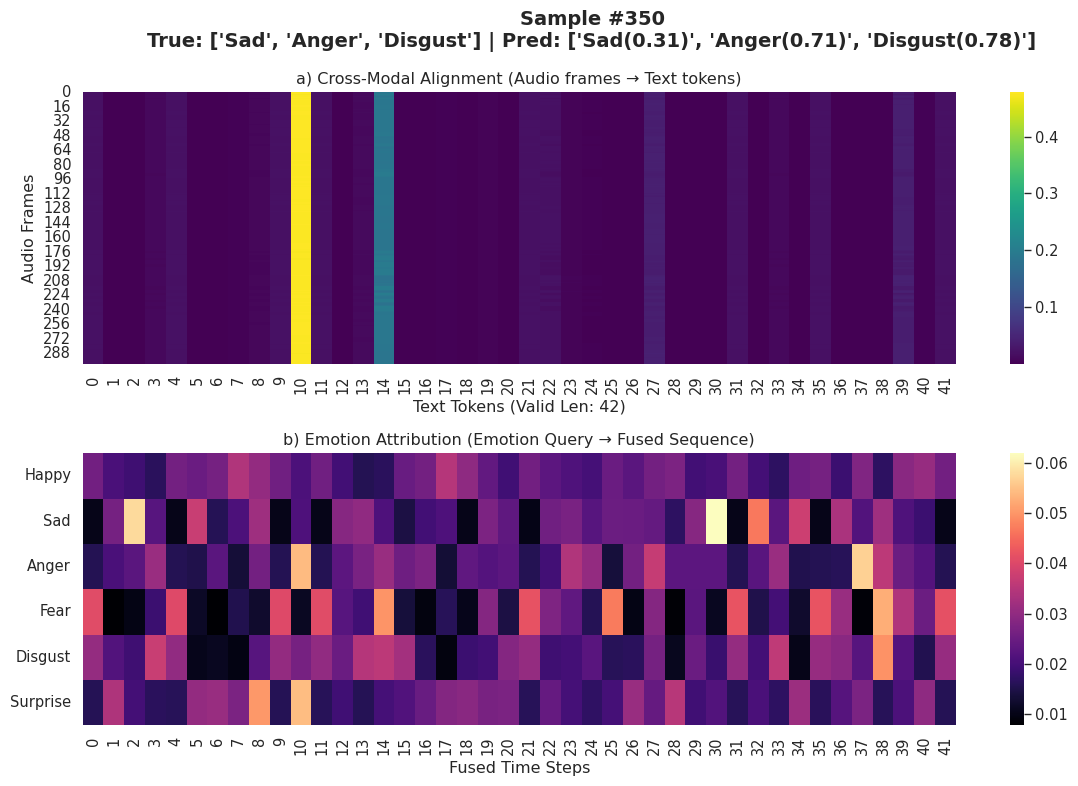


🎉 Found perfect sample #17! Global Index: 352
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.42 0.02 0.02 0.02 0.   0.05])


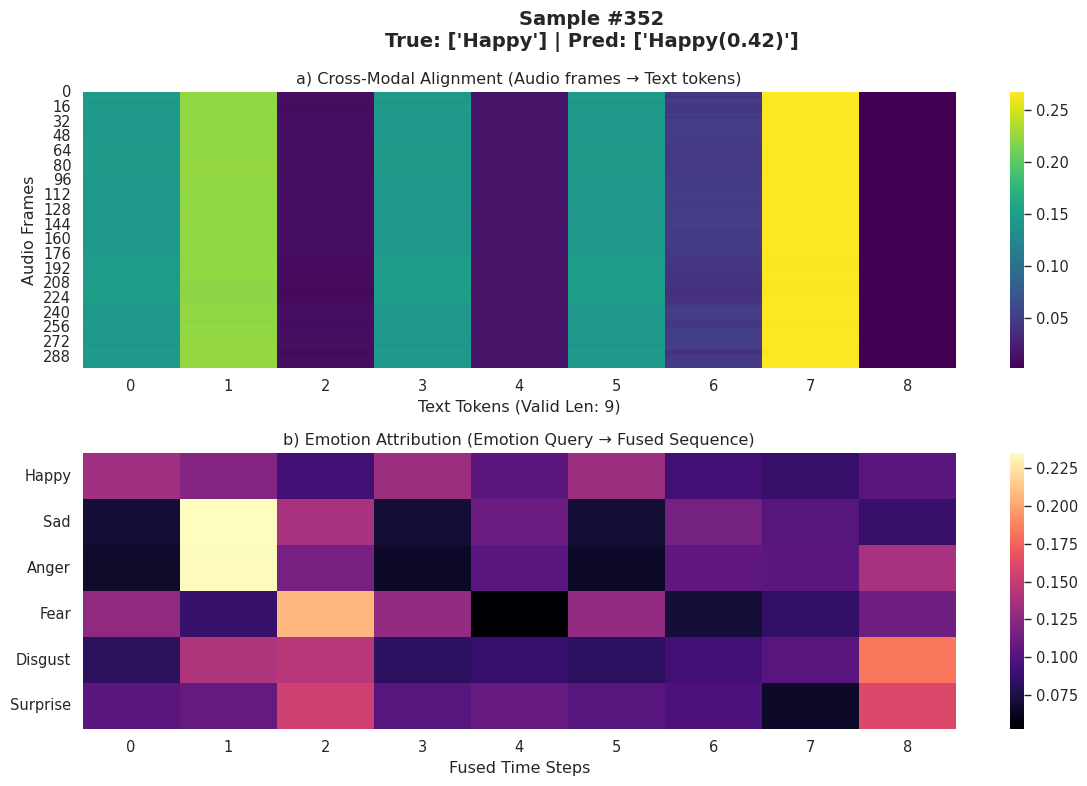


🎉 Found perfect sample #18! Global Index: 353
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.32 0.01 0.02 0.01 0.   0.01])


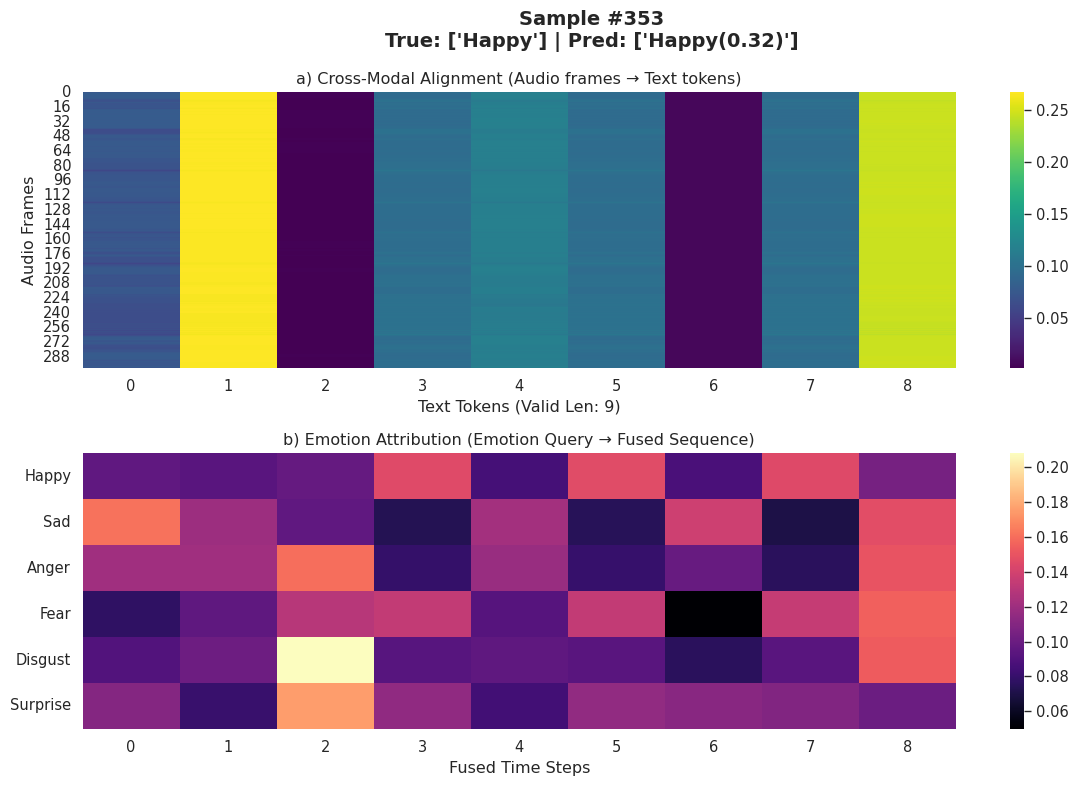


🎉 Found perfect sample #19! Global Index: 371
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.28 0.01 0.03 0.01 0.   0.01])


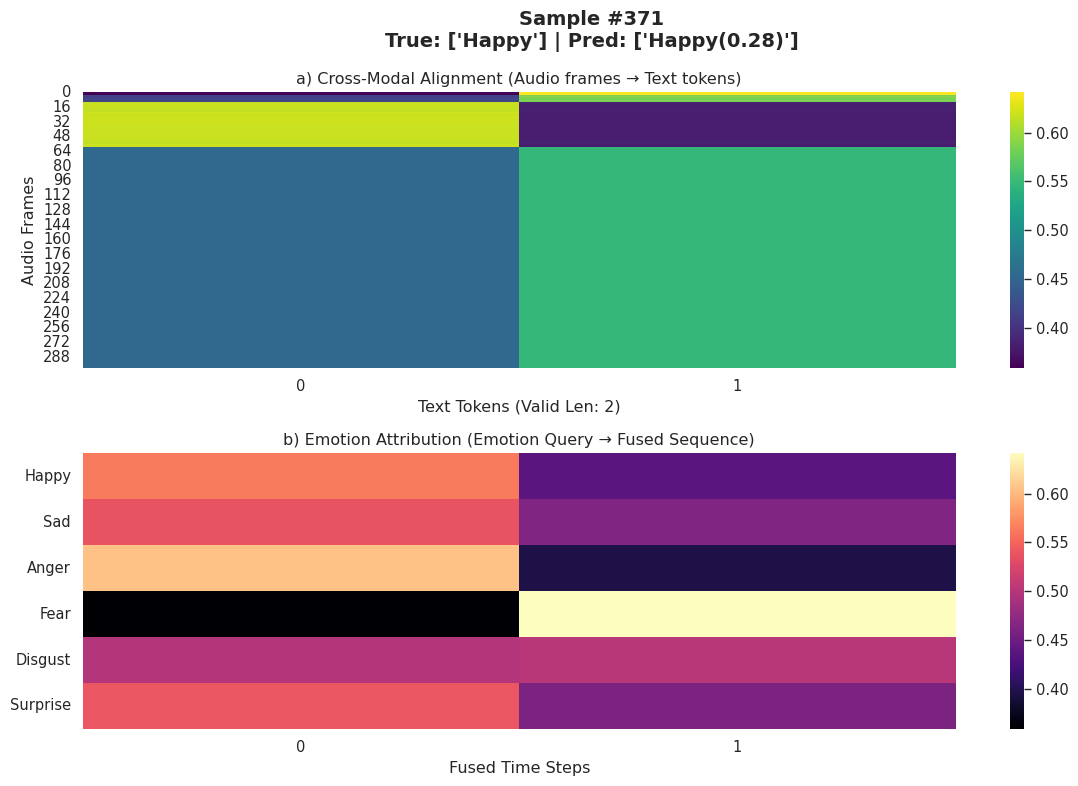


🎉 Found perfect sample #20! Global Index: 388
Emotion Categories: ['Happy']
True Labels: [1 0 0 0 0 0]
Predicted Result: [1 0 0 0 0 0] (Prob: [0.34 0.03 0.03 0.02 0.   0.04])


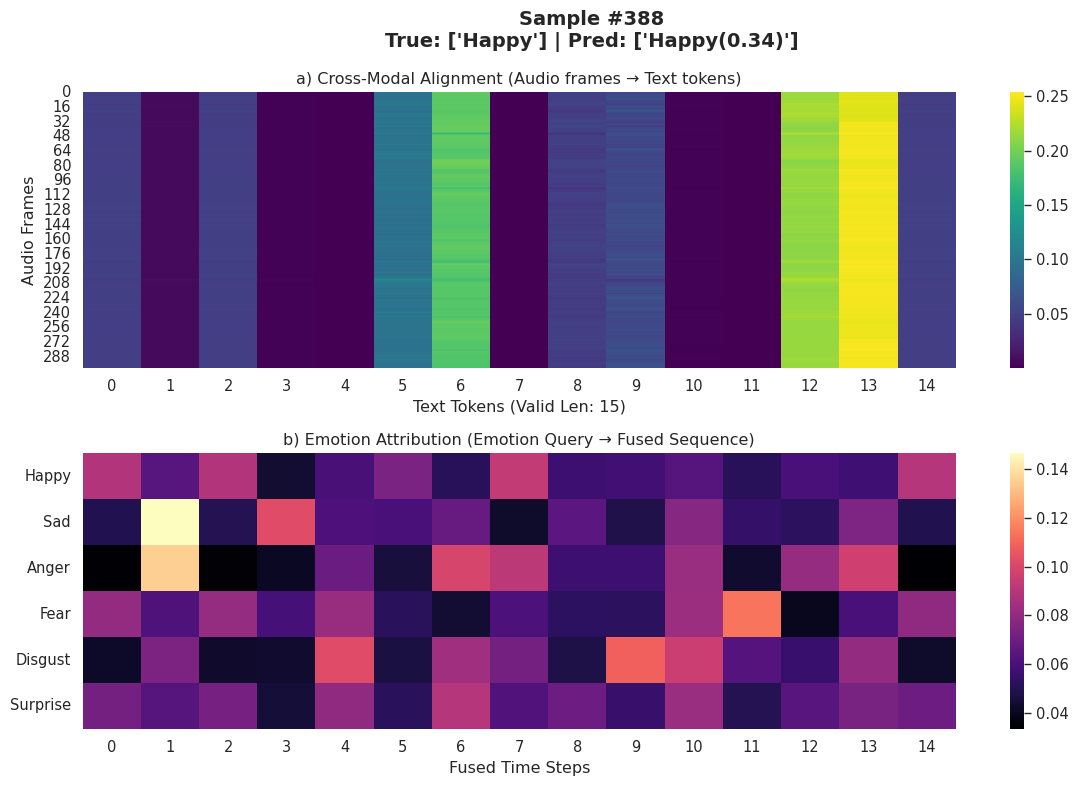

In [52]:
import numpy as np
# (Assuming EMOTIONS, y_true, probs, plot_case_study function, and an existing 'thresholds' variable are defined)

print("Searching for samples with [Exact Match] predictions...")

# 1. Ensure we have thresholds (if not loaded, use the best values from previous logs)
# The thresholds used here are hardcoded for v2 model: [0.05, 0.05, 0.15, 0.2, 0.25, 0.35]
try:
    # Attempt to use the previously loaded 'thresholds' variable
    current_ths = thresholds
except NameError:
    # If not defined, manually hardcode the best thresholds for the v2 model
    current_ths = np.array([0.05, 0.05, 0.15, 0.20, 0.25, 0.35])

print(f"Using thresholds for determination: {current_ths}")

found_count = 0
target_count = 20  # We are looking for 20 examples for selection

# Iterate through the first 1000 samples for which we saved attention maps
for i in range(min(1000, len(probs))):

    # Get the true labels (0 or 1)
    t = y_true[i]

    # Get the predicted labels (0 or 1) -> CRITICAL: Use the custom thresholds, not 0.5
    p_prob = probs[i]
    p_bin = (p_prob >= current_ths).astype(int)

    # === Core Check: Are they exactly equal? ===
    # AND Exclude all-zero samples (Neutral), as an all-black plot is not illustrative
    if np.array_equal(t, p_bin) and t.sum() > 0:

        found_count += 1
        print(f"\n🎉 Found perfect sample #{found_count}! Global Index: {i}")

        # Print detailed comparison
        active_indices = np.where(t == 1)[0]
        emotion_names = [EMOTIONS[idx] for idx in active_indices]
        print(f"Emotion Categories: {emotion_names}")
        print(f"True Labels: {t}")
        print(f"Predicted Result: {p_bin} (Prob: {np.round(p_prob, 2)})")

        # Calculate Batch and Sample ID (required by plot_case_study)
        BATCH_SIZE = 8
        b_idx = i // BATCH_SIZE
        s_idx = i % BATCH_SIZE

        # Call the plotting function
        # Note: We are temporarily modifying the plot_case_study logic here for accuracy,
        # (or you can just use the existing one, as long as the plot is correct)
        plot_case_study(b_idx, s_idx)

        if found_count >= target_count:
            break

if found_count == 0:
    print("Could not find any Perfect Matches in the first 1000 samples. MOSEI is too difficult!")
    print("Suggestion: Look for a sample with 'minimal error'.")